In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from qkit.analysis.semiconductor.loaders.Loaderh5 import Loaderh5
from qkit.analysis.semiconductor.analyzers.AnalyzerTimetraceSpectralNoiseDensity import AnalyzerTimetraceSpectralNoiseDensity
from qkit.analysis.semiconductor.plotters.PlotterTimetraceSpectralNoiseDensity import PlotterTimetraceSpectralNoiseDensity
from qkit.analysis.semiconductor.analyzers.AnalyzerPeakTracker_Daniel import AnalyzerPeakTracker
from qkit.analysis.semiconductor.plotters.PlotterPlungerTimetrace3D import PlotterPlungerTimetrace3D
from qkit.analysis.semiconductor.plotters.PlotterPlungerTraceFit import PlotterPlungerTraceFit
from qkit.analysis.semiconductor.plotters.PlotterPlungerTraceTimestampsDifference import PlotterPlungerTraceTimestampsDifference
from qkit.analysis.semiconductor.plotters.PlotterTimetraceJumpsHistogram import PlotterTimetraceJumpsHistogram
from qkit.analysis.semiconductor.main.SlicerPlungerTimetrace import SlicerPlungerTimetrace
from qkit.analysis.semiconductor.loaders.Loader_spectrum_np import Loader_spectrum_np
from qkit.analysis.semiconductor.savers.Saver_spectrum_np import Saver_spectrum_np
from qkit.analysis.semiconductor.savers.Saver_json import Saver_json
from qkit.analysis.semiconductor.main.pre_formatted_figures import SemiFigure
from qkit.analysis.semiconductor.loaders.LoaderJSON import LoaderJSON


import os
import matplotlib.pyplot as plt
import pathlib
from scipy.stats import sem
from scipy import mean

from qkit.analysis.semiconductor.analyzers.AnalyzerPeakTracker import Analyzer as Peak_hunt
from qkit.analysis.semiconductor.analyzers.AnalyzerTimetraceJumps  import Analyzer as jump_count
from qkit.analysis.semiconductor.main.fit_functions import gauss_function

QKIT configuration initialized -> available as qkit.cfg[...]


In [3]:
def linear(x, a, b):
    return a * x + b

def bilinear2(x, a, b, c, switch_point):
    x = np.array(x)
    part1 = a * x[x <= switch_point] + b
    part2 = c * x[x > switch_point] + (a - c) * switch_point + b
    return np.concatenate((part1, part2))

def func_power2(x, *params):
    x = np.array(x)
    if len(params) == 2:
        return params[1] * x ** params[0]
    else:
        part1 = params[1] * x[x <= params[3]] ** params[0]
        part2 = params[1]/(params[3] ** (params[2]-params[0])) * x[x > params[3]] ** params[2]
        return np.concatenate((part1, part2))

def get_bcv(key):
    return float(key.split("tg")[0])

def get_tgv(key):
    return float(key.split("tg")[1].split("vr")[0])

def get_vref(key):
    return float(key.split("vr")[1].split("side")[0])

def get_side(key):
    return key.split("side")[1].split("num")[0]

def extract_lowest_tgv(wanted_bcv, wanted_side, data_dict):
    tgvs = []
    matching_key = []
    for key in data_dict.keys():
        bcv = get_bcv(key)
        tgv = get_tgv(key)
        side = get_side(key)
        if bcv == wanted_bcv and side == wanted_side:
            tgvs.append(tgv)
            matching_key.append(key)
            
    val = min(tgvs)
    idx = tgvs.index(val)
    return val, matching_key[idx]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def remove_jumps(peak_track, jump_min_height):
    difference = np.diff(peak_track)
    jumps_height = difference[abs(difference) >= jump_min_height]
    jumps_idx = np.flatnonzero(abs(difference) >= jump_min_height) + 1
    
    prev_idx = 0
    jumped = 0
    baseline = np.array([])
    
    for idx, height in zip(jumps_idx, jumps_height):
        len_x = idx - prev_idx
        prev_idx = idx    
        baseline = np.concatenate((baseline, np.full(len_x, jumped)))
        jumped += height

    baseline = np.concatenate((baseline, np.full(len(peak_track) - len(baseline), jumped)))
    return peak_track - baseline

# Choose the Data

In [104]:
date_time_string = "20220913/143347"
date = date_time_string.split("/")[0]
time = date_time_string.split("/")[1]
filepath = f"smb://nanospin@phi-ndus/o/data/{date}/{time}_2D_Peak_tracking/{time}_2D_Peak_tracking.h5"
savepath = os.path.join("/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/",
                        str(pathlib.Path(filepath).parents[1]).split("/")[-1],
                        str(pathlib.Path(filepath).parents[0]).split("/")[-1])
overview_path = "/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/"

configpath = "/home/ws/lr1740/Dokumente/Doktorarbeit/Sonstiges/sftp_config.txt"

saver = Saver_json(savepath)
saver.append_to_file = True
saver_overview = Saver_json(overview_path)
bcv = input("Specify current bias cooling voltage in V: ")

saver_overview.fname = "P35B3"
saver_overview.append_to_file = True

print("Savepath: " + savepath)

settings = {"file_info" : {
                "filepath" : filepath,
                "savepath" : savepath,
                "analysis" : "plunger_sweep_timetrace"},
            "meas_params" : {
                "measurement_amp" : 100e-6,
                "voltage_divider" : 3,
                "IVgain" : 1e8,
                "in_line_R": 40e3},
            "authentication" : {
                "configpath" : configpath}
            }

Specify current bias cooling voltage in V: -0.8
Savepath: /V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/20220913/143347_2D_Peak_tracking


In [105]:
loader = Loaderh5()
data, _ = loader.load(settings)
print(data.keys())
print("\n")
print(data["static_voltages"])
vr = input("Specify reference voltage in V: ")

Done loading file, formatting now...
dict_keys(['demod0.r0', 'demod0.timestamp0', 'demod0.x0', 'demod0.y0', 'gate_6', 'measurement', 'number', 'settings', 'static_voltages'])


['{\n    "gate10_out": -0.42755126953125,\n    "gate11_out": -0.42755126953125,\n    "gate12_out": -0.42755126953125,\n    "gate13_out": -0.42755126953125,\n    "gate14_out": -0.42755126953125,\n    "gate15_out": -0.42755126953125,\n    "gate16_out": -0.42755126953125,\n    "gate17_out": -0.42755126953125,\n    "gate18_out": -0.42755126953125,\n    "gate19_out": -0.42755126953125,\n    "gate20_out": -0.42755126953125,\n    "gate21_out": -0.42755126953125,\n    "gate22_out": -0.42755126953125,\n    "gate23_out": -0.42755126953125,\n    "gate4_out": 1.3661,\n    "gate5_out": 0.9625244140625,\n    "gate6_out": -0.36773681640625,\n    "gate7_out": 1.09283447265625,\n    "gate9_out": -0.42755126953125\n}']


KeyboardInterrupt: Interrupted by user

In [76]:
side = input("Specify side of SET (l/r): ")
tgv = input("Specify current top gate voltage in V: ")
while side != "l" and side != "r":
    side = input("Specify side of SET (l/r): ")
    
analysis_key = f"{bcv}tg{tgv}vr{vr}side{side}"

demod_prefix = "demod0&4"
if side == "l":
    demod_idx = 0
else:
    demod_idx = 4
    
node_timestamp = f"{demod_prefix}.timestamp{demod_idx}"
node_x = f"{demod_prefix}.x{demod_idx}"
node_y = f"{demod_prefix}.y{demod_idx}"
node_r = f"{demod_prefix}.r{demod_idx}"

gates = "gates_6_16"

Specify side of SET (l/r): l
Specify current top gate voltage in V: 1.429


In [69]:
print(analysis_key)

0.25tg1.927vr0.699sidel


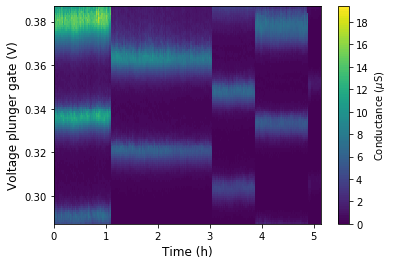

In [77]:
plotter = PlotterPlungerTimetrace3D()
plotter.max_cond = None
plotter.plot(settings, data, [node_timestamp, gates , node_r])

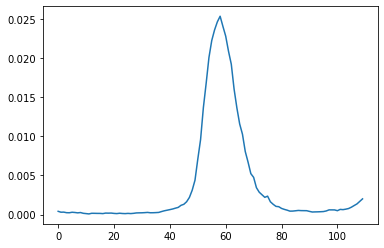

In [72]:
plt.plot(data[node_r][3])

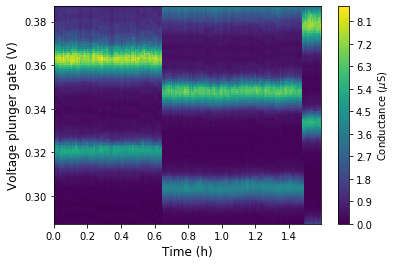

In [78]:
#%% Slice Data and Plot
slicer = SlicerPlungerTimetrace()
slicer.beginning, slicer.ending = 2.4, 4 # in hours
data_sliced = slicer.slice(data, [node_timestamp, gates , node_r])

plotter = PlotterPlungerTimetrace3D()
plotter.max_cond = None
plotter.savename = "plunger_timetrace_sliced"
plotter.plot(settings, data_sliced, [node_timestamp, gates , node_r])

In [92]:
yeno = input("Do you wish to continue to work with the sliced data? [y/n]")
if yeno == "y":
    data_raw = data.copy()
    data = data_sliced
    print("You are now working with the sliced data")

Do you wish to continue to work with the sliced data? [y/n]y
You are now working with the sliced data


# Let the peak hunt begin!

## The bloodmoon has risen over the city of Yharnam...

Number of tracked peaks: 2
Length of chosen peak track: 700
Length of samples: 700


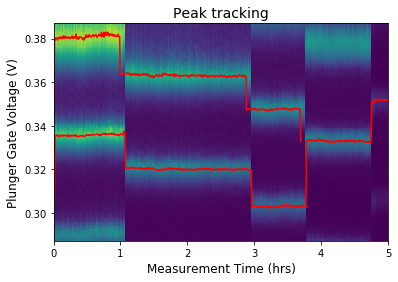

In [90]:
peak_hunter = Peak_hunt(data[node_r], data[node_timestamp], data[gates])
peak_hunter.pf.min_peak_height = 0.001
peak_hunter.pf.min_peak_width = 5
peak_hunter.pf.min_peak_distance = None #Can also be None, for no min distance
peak_hunter.pf.fit_interval_peak_relheight = 0.8
peak_hunter.rel_jump_height = 2
tracked_peaks = peak_hunter.analyze()

print(f"Number of tracked peaks: {len(tracked_peaks['tracked_peak_positions'])}")
index_of_peak = 0
print(f"Length of chosen peak track: {len(tracked_peaks['tracked_peak_positions'][index_of_peak])}")
print(f"Length of samples: {len(data[node_r])}")

saver.add_info(f"{node_r}_tracked_peaks", tracked_peaks)

fig, ax1 = plt.subplots()
ax1.set_title("Peak tracking", fontsize = 14)
ax1.set_xlabel("Measurement Time (hrs)", fontsize = 12)
ax1.set_ylabel("Plunger Gate Voltage (V)", fontsize = 12)
ax1.set_axisbelow(True) # pushes grid to background
fig.set_facecolor("White")

ax1.pcolor(tracked_peaks["time_axis"]/3600, data[gates], np.transpose(data[node_r]))
for tracked_peak in tracked_peaks["tracked_peak_positions"]:
    length = min([len(tracked_peaks["time_axis"]), len(tracked_peak)])
    ax1.plot(tracked_peaks["time_axis"][:length]/3600, tracked_peak[:length], color = "r")
fig.savefig(os.path.join(savepath, "peak_tracking.png"), dpi = 400)

# Spectral noise density Calculation

In [91]:
def linear(x, a, b):
    return a * x + b

def bilinear2(x, a, b, c, switch_point):
    x = np.array(x)
    part1 = a * x[x <= switch_point] + b
    part2 = c * x[x > switch_point] + (a - c) * switch_point + b
    return np.concatenate((part1, part2))

-8.012508550030827


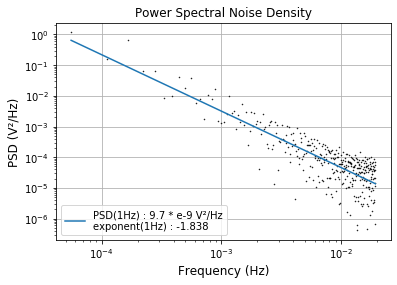

In [92]:
type_of_fit = "lin"
if type_of_fit == "lin":
    fit_func = linear
    guess = [-1, 1]
elif type_of_fit == "bilin":
    fit_func = bilinear2
    guess = [-2, 1, -1, -3]
    
sampling_f = tracked_peaks["time_axis"][1]**-1
peak_no = 0
noise_calculator = AnalyzerTimetraceSpectralNoiseDensity(tracked_peaks["tracked_peak_positions"][peak_no],\
                                                        sampling_f, fit_func = fit_func)

noise_calculator.welch_segment_length = 300
noise_calculator.guess = guess
saver.add_info(f"{node_r}_peak{peak_no}_welch_segment_length", noise_calculator.welch_segment_length)
saver.add_info(f"{node_r}_peak{peak_no}_fit_interval", noise_calculator.fit_interval)

spectral_result = noise_calculator.analyze()
saver.add_info(f"{node_r}_peak{peak_no}_spectrum", spectral_result)
saver_overview.add_info(f"{node_r}_peak{peak_no}_spectrum", spectral_result)

fit = noise_calculator.fit()
saver.add_info(f"{node_r}_peak{peak_no}_SNDfit_parameters", fit)
saver_overview.add_info(f"{node_r}_peak{peak_no}_SNDfit_parameters", fit)

f, s = spectral_result["freq"], spectral_result["spectrogram"]
saving_path = os.path.join(settings["file_info"]["savepath"], node_r)

plotter_SND = PlotterTimetraceSpectralNoiseDensity(saving_path, [f,s], fit)
plotter_SND.plot()

# Jump analysis

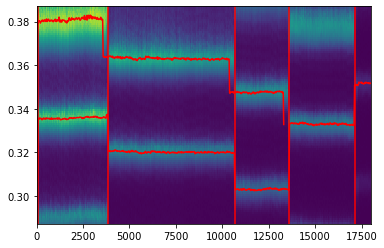

In [93]:
#peak_no = 0
jump_analysis = jump_count(tracked_peaks["tracked_peak_positions"][peak_no], tracked_peaks["time_axis"])
jump_analysis.big_jump_minimum_height = 2e-3
jump_analysis.bin_count = 100
jump_analysis.range = (-0.01, 0.01)
jump_analysis.guess = [20, 0, 0.0002]
jump_hist, big_jumps = jump_analysis.analyze()
popt = jump_analysis.fit()

saver.add_info(f"{node_r}_peak{peak_no}_jumphist", jump_hist)
saver.add_info(f"{node_r}_peak{peak_no}_big_jumps", big_jumps)
saver.add_info(f"{node_r}_peak{peak_no}_jumpfit_parameters", popt)

saver_overview.add_info(f"{node_r}_peak{peak_no}_big_jumps", big_jumps)
saver_overview.add_info(f"{node_r}_peak{peak_no}_jumpfit_parameters", fit)

plt.pcolor(tracked_peaks["time_axis"], data[gates], np.transpose(data[node_r]))
for tracked_peak in tracked_peaks["tracked_peak_positions"]:
    length = min([len(tracked_peaks["time_axis"]), len(tracked_peak)])
    plt.plot(tracked_peaks["time_axis"][:length], tracked_peak[:length], color = "r")
for jump_time in big_jumps["time_of_big_jumps"]:
    plt.axvline(jump_time, color = "r")

FHWM of the guassian distribution: 0.6954538933146511 mV


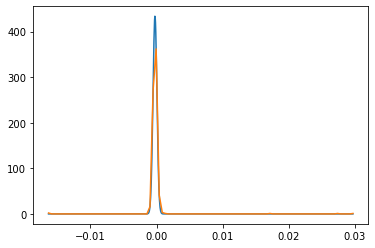

In [94]:
print(f"FHWM of the guassian distribution: {2.35482e3 * popt[-1]} mV")
x = np.linspace(min(jump_hist["jump_height"]), max(jump_hist["jump_height"]), 1000)
y = gauss_function(x, *popt)
plt.plot(x, y)
plt.plot(jump_hist["jump_height"], jump_hist["jumps_per_bin"])

# Save your analysis!

In [95]:
saver.save()

ovw = saver_overview.additional_info

saver_saver_overview = Saver_json(overview_path) #Save your saved data to be safe


saver_saver_overview.fname = saver_overview.fname
saver_saver_overview.append_to_file = True

saver_saver_overview.additional_info = {analysis_key : ovw}
saver_saver_overview.save()

# Look at the big picture!

In [87]:
from qkit.analysis.semiconductor.loaders.LoaderJSON import LoaderJSON
overview_path = "/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/"
sample = "P35B3"#_post_analysis"
fname = f"{sample}.json"

loader = LoaderJSON()
ovw_data = loader.load(os.path.join(overview_path, fname))
ovw_data.keys()

dict_keys(['0tg0.957vr0.17sidel', '0tg1.106vr0.17sider', '0.75tg1.239vr0.604sidel', '0.75tg1.413vr0.604sider', '-0.5tg1.878vr-0.446sider', '-0.5tg0.38vr-0.446sidel', '1.5tg3.31vr0.655sidel', '0.75tg1.414vr0.604sidel'])

In [84]:
def get_bcv(key):
    return float(key.split("tg")[0])

def get_tgv(key):
    return float(key.split("tg")[1].split("vr")[0])

def get_vref(key):
    return float(key.split("vr")[1].split("side")[0])

def get_side(key):
    return key.split("side")[1].split("num")[0]

def extract_lowest_tgv(wanted_bcv, wanted_side, data_dict):
    tgvs = []
    matching_key = []
    for key in data_dict.keys():
        bcv = get_bcv(key)
        tgv = get_tgv(key)
        side = get_side(key)
        if bcv == wanted_bcv and side == wanted_side:
            tgvs.append(tgv)
            matching_key.append(key)
            
    if tgvs:
        val = min(tgvs)
        idx = tgvs.index(val)
        return val, matching_key[idx]
    else:
        return None, None
    

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [61]:
key1 = list(ovw_data.keys())[0]
print(key1)
print(get_bcv(key1))
print(get_tgv(key1))
print(get_vref(key1))
print(get_side(key1))

0.75tg1.602vr1.104
0.75
1.602
1.104


IndexError: list index out of range

In [13]:
class bias_cool_plotter():
    def __init__(self, data_dict, y_maker, sample, y_scale = "log"):
        self.data_dict = data_dict
        self.y_maker = y_maker
        self._build_x_axis()
        self._build_y_axis()
        print(self.x_axis)
        print(self.y_axis)
        self.fig, self.ax1 = plt.subplots()
        self.ax1.set_title("Total noise power vs bias cooling")
        self.ax1.set_xlabel("Bias Cooling Voltage (V)")
        self.ax1.set_ylabel("Integrated Noise Power (V²)")
        self.ax1.set_yscale(y_scale)
        self.ax1.set_ylim(min(self.y_axis), max(self.y_axis))
        self.ax1.plot(self.x_axis, self.y_axis)
        
        self.set_dpi = 400
        #self.fig.set_bbox_inches = "tight"
        self.fig.save_as = ".png"
        self.fig.set_facecolor("White")
        self.ax1.set_axisbelow(True) # pushes grid to background
        self.ax1.title.set_size(fontsize=14)
        self.ax1.xaxis.label.set_size(fontsize=12)
        self.ax1.yaxis.label.set_size(fontsize=12)
        self.ax1.grid()
        self.fig.savefig(os.path.join(overview_path, f"{sample}_integrated_noise.png"), dpi = self.set_dpi)
    
    def _build_x_axis(self):
        x_vals = set()
        for key in self.data_dict.keys():
            bcv = get_bcv(key)
            x_vals.add(bcv)
        self.x_axis = sorted(list(x_vals))
    
    def _build_y_axis(self):
        self.y_axis = []
        for x_value in self.x_axis:
            y_value = self.y_maker(self.data_dict, x_value)
            self.y_axis.append(y_value)
    
def test_y_maker(data_dict, x_value):    
    return extract_lowest_tgv(x_value)

def format_float(float_no):
    if float_no.is_integer():
        key = f'{float_no:.0f}'
    else:
        key = f'{float_no}'
    return key

def find_key(data_dict, part_key):
    keys = data_dict.keys()
    #print(keys)
    #print(part_key)
    for key in keys:
        if part_key in key:
            return key
    return "not_found"

def one_mHz_value(data_dict, x_value):
    tgv, key = extract_lowest_tgv(x_value)
    #key = f"{format_float(x_value)}tg{tgv}"
    
    spectrum_key = find_key(data_dict[key], "spectrum")
    freqs = data_dict[key][spectrum_key]["freq"]
    spec = data_dict[key][spectrum_key]["spectrogram"]
    one_mHz_idx = find_nearest_idx(freqs, 1e-3)
    return spec[one_mHz_idx]

def func_power2(x, *params):
    x = np.array(x)
    if len(params) == 2:
        return params[1] * x ** params[0]
    else:
        part1 = params[1] * x[x <= params[3]] ** params[0]
        part2 = params[1]/(params[3] ** (params[2]-params[0])) * x[x > params[3]] ** params[2]
        return np.concatenate((part1, part2))

def one_mHz_value_fit(data_dict, x_value):
    tgv, key = extract_lowest_tgv(x_value)
    #key = f"{format_float(x_value)}tg{tgv}"
    
    fit_key = find_key(data_dict[key], "SNDfit")
    fit_pars = data_dict[key][fit_key]["popt"]
    
    return func_power2(1e-3, *fit_pars)

def integrated_noise_power(data_dict, x_value):
    tgv, key = extract_lowest_tgv(x_value)
    #key = f"{format_float(x_value)}tg{tgv}"
    
    spectrum_key = find_key(data_dict[key], "spectrum")
    freqs = data_dict[key][spectrum_key]["freq"]
    spec = data_dict[key][spectrum_key]["spectrogram"]
    integral = np.sum(np.diff(freqs) * spec[:-1])
    return integral

def integrated_noise_power_fit(data_dict, x_value):
    tgv, key = extract_lowest_tgv(x_value, "l", data_dict)
    #key = find_key(data_dict, str(tgv))
    print(tgv)
    print(key)
    sub_key = "r0_peak0"
    fit_key = find_key(data_dict[key], sub_key + "_SNDfit")
    print(fit_key)
    if fit_key != "not_found":
        fit_pars = data_dict[key][fit_key]["popt"]

        f_min = 1e-4
        f_max = 1e-2

        band = np.linspace(f_min, f_max, 100000)
        spec = func_power2(band, *fit_pars)

        integral = np.sum(np.diff(band) * spec[:-1])
        return integral
    else:
        return np.nan

def fwhm(data_dict, x_value):
    tgv, key = extract_lowest_tgv(x_value)
    #key = f"{format_float(x_value)}tg{tgv}"
    
    jumpfit_key = find_key(data_dict[key], "jumpfit")
    popt = data_dict[key][jumpfit_key]["popt"]
    if len(popt) == 4:
        fwhm = data_dict[key][jumpfit_key]["popt"][-1]
    else:
        fwhm = 0
    return fwhm

def length_plot(data_dict, x_value):
    tgv, key = extract_lowest_tgv(x_value)
    #key = f"{format_float(x_value)}tg{tgv}"
    spectrum_key = find_key(data_dict[key], "r4_peak0_spectrum")
    freqs = data_dict[key][spectrum_key]["freq"]
    print(len(freqs))
    print(min(freqs))
    print(max(freqs))
    return len(freqs)

bcp = bias_cool_plotter(ovw_data, integrated_noise_power_fit, sample)

NameError: name 'ovw_data' is not defined

In [90]:
ovw_data["0.75tg1.104vr1.104sidel"].keys()

KeyError: '0.75tg1.104vr1.104sidel'

In [91]:
p35_b3_x_axis = bcp.x_axis[:]
p35_b3_y_axis = bcp.y_axis[:]

In [75]:
#Done Samples:
p35_b4_x_axis
p35_b4_y_axis

p35_b3_x_axis
p35_b3_y_axis

p35_b1_y_axis
p35_b1_y_axis

[0.00020310787652103387,
 2.3523320996339547e-05,
 0.0003767679261758867,
 1.0901465928507918e-05,
 5.0115537164900075e-06,
 4.2162141374273204e-07,
 9.399752489652295e-07,
 3.977015929895646e-05,
 9.603997936154829e-05,
 4.5053375116834815e-05,
 2.378668328994797e-06]

# Bias cooling results vs. min integration freq

0.38
-0.5tg0.38vr-0.446sidel
1.106
0tg1.106vr0.17sidel
1.239
0.75tg1.239vr0.604sidel
3.31
1.5tg3.31vr0.655sidel
[-0.5, 0.0, 0.75, 1.5]
[2.7906591219636985e-08, 6.819744002666638e-07, 5.252054358886223e-08, 3.411788358516969e-05]
0.38
-0.5tg0.38vr-0.446sidel
1.106
0tg1.106vr0.17sidel
1.239
0.75tg1.239vr0.604sidel
3.31
1.5tg3.31vr0.655sidel
[-0.5, 0.0, 0.75, 1.5]
[1.8560690302086095e-08, 3.619782015393523e-07, 3.670130394303255e-08, 1.6738160095794387e-05]
0.38
-0.5tg0.38vr-0.446sidel
1.106
0tg1.106vr0.17sidel
1.239
0.75tg1.239vr0.604sidel
3.31
1.5tg3.31vr0.655sidel
[-0.5, 0.0, 0.75, 1.5]
[1.34918102773828e-08, 2.3225676359368754e-07, 2.7451265084726622e-08, 1.029397752051534e-05]
0.38
-0.5tg0.38vr-0.446sidel
1.106
0tg1.106vr0.17sidel
1.239
0.75tg1.239vr0.604sidel
3.31
1.5tg3.31vr0.655sidel
[-0.5, 0.0, 0.75, 1.5]
[1.0062591111061684e-08, 1.5907400657915902e-07, 2.0889856201836133e-08, 6.853572572709006e-06]
0.38
-0.5tg0.38vr-0.446sidel
1.106
0tg1.106vr0.17sidel
1.239
0.75tg1.239vr0.604si

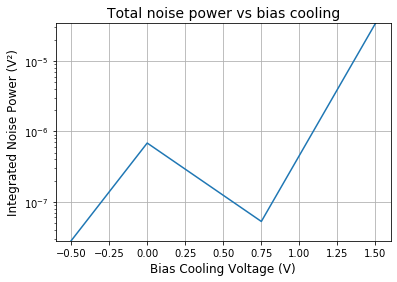

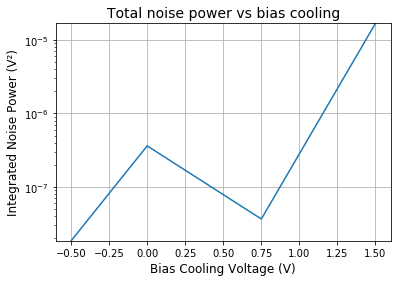

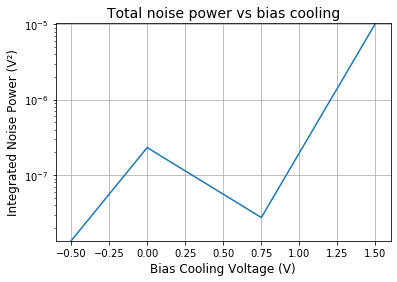

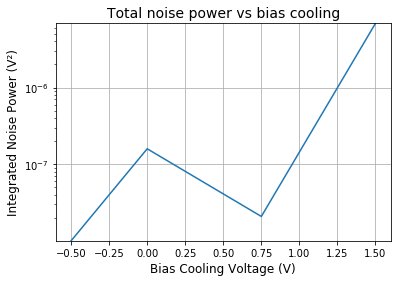

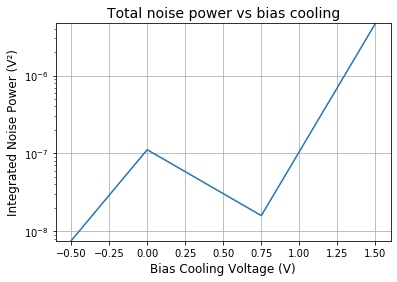

In [48]:
def integrated_noise_power_fit_fmin_fmax(f_min, f_max, data_dict, x_value):
    tgv, key = extract_lowest_tgv(x_value, data_dict)
    #key = find_key(data_dict, str(tgv))
    print(tgv)
    print(key)
    sub_key = "r0_peak0"
    fit_key = find_key(data_dict[key], sub_key + "_SNDfit")
    #print(fit_key)
    if fit_key != "not_found":
        fit_pars = data_dict[key][fit_key]["popt"]

        band = np.linspace(f_min, f_max, 100000)
        spec = func_power2(band, *fit_pars)

        integral = np.sum(np.diff(band) * spec[:-1])
        return integral

min_freqs = [1e-4, 2e-4, 3e-4, 4e-4, 5e-4]
for fmin in min_freqs:
    f = lambda data_dict, x_value: integrated_noise_power_fit_fmin_fmax(fmin, 1e-3, data_dict, x_value)
    bias_cool_plotter(ovw_data, f, sample)

In [88]:
import scipy.signal as ss

dividers = range(1,3)
min_freqs = []
for div in dividers:
    signal = np.array_split(tracked_peaks["tracked_peak_positions"][0], 1)
    print(type(signal))
    freqs, times, spectrogram = ss.spectrogram(signal[:int(len(signal)/div)], tracked_peaks["time_axis"][1]**-1)
    min_freqs.append(freqs[1])

print(min_freqs)

<class 'list'>


AttributeError: 'list' object has no attribute 'shape'

# Automatic parameter recording in the indiv analysis files

In [107]:
def load_file(date_time_string, connection_type = "sftp"):
    date = date_time_string.split("/")[0]
    time = date_time_string.split("/")[1]
    
    if connection_type == "sftp":
        filepath = ("sftp://tp1435@os-login.lsdf.kit.edu/kit/phi/"
                    "projects/nanospin/SEMICONDUCTOR_SYSTEMS/data/"
                    f"{date}/{time}_2D_Peak_tracking/"
                    f"{time}_2D_Peak_tracking.h5")
    elif connection_type == "smb":
        filepath = (f"smb://nanospin@phi-ndus/o/data/{date}/{time}"
                    f"_2D_Peak_tracking/{time}_2D_Peak_tracking.h5")
    else:
        raise ValueError("Invalid connection type. Currently supporting sftp and smb.")
    
    settings = {"file_info" : {
                "filepath" : filepath},
            "authentication" : {
                "configpath" : configpath}
            }
    
    loader = Loaderh5()
    return loader.load(settings)

def create_saver(date_time_string):
    date = date_time_string.split("/")[0]
    time = date_time_string.split("/")[1]
    
    filepath = ("sftp://tp1435@os-login.lsdf.kit.edu/kit/phi/"
                "projects/nanospin/SEMICONDUCTOR_SYSTEMS/data/"
                f"{date}/{time}_2D_Peak_tracking/"
                f"{time}_2D_Peak_tracking.h5")
    savepath = os.path.join("/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/",
                        str(pathlib.Path(filepath).parents[1]).split("/")[-1],
                        str(pathlib.Path(filepath).parents[0]).split("/")[-1])
    saver = Saver_json(savepath)
    saver.append_to_file = True
    return saver

def convert_dict_string(dict_string):
    dict_string_split = dict_string.split("\n")
    dict_string_split.remove("}")
    dict_string_split.remove("{")

    static_voltages = {}
    for raw_kv_pair in dict_string_split:
        raw_k, raw_v = raw_kv_pair.split(":")
        v = float(raw_v.replace(",", ""))
        k = raw_k.replace(" ", "").replace('"', "")
        static_voltages[k] = v
    return static_voltages

def get_bcv_forh5(settings_string):
    try:
        bcv = float(settings_string.split('"bias_cooling_v"')[1].split(": ")[1].split(",")[0])
    except IndexError:
        print("No bcv has been found.")
        print(date_time)
        bcv = float(input("Please input bcv manually."))
    return round(bcv, 3)

def get_tgv_forh5(static_voltages, side):
    if side == "l":
        key = "gate4_out"
    elif side == "r":
        key = "gate14_out"
    return round(static_voltages[key], 3)
    
def get_most_common_voltage_forh5(static_voltages):
    voltages = list(static_voltages.values())
    most_common_voltage = max(set(voltages), key = voltages.count)
    return round(most_common_voltage + 0.5, 3)

In [8]:
#B3
date_times = {"20220501/140941", "20220502/014148", "20220517/104543", "20220517/232824", "20220518/120037"}
print(len(date_times))

5


In [9]:
#B4
date_times = {"20220408/173804", "20220410/014626", "20220410/174848", "20220421/011122",
              "20220421/084935", "20220423/194835", "20220424/095946", "20220424/212521",
              "20220528/125951", "20220529/014453", "20220529/194625", "20220531/174026",
              "20220601/023259", "20220602/211422", "20220603/015345", "20220603/015345", 
              "20220603/174843"}
print(len(date_times))

16


In [109]:
#A4
date_times = {"20220810/011635",
"20220810/145859",
"20220827/232944",
"20220828/163623",
"20220829/122037",
"20220830/115720",
"20220831/012540",
"20220831/132139",
"20220901/093721",
"20220902/000231",
"20220902/191607",
"20220902/201312",
"20220902/223428",
"20220903/122853",
"20220904/001904",
"20220904/142951",
"20220905/063708",
"20220905/213523",
"20220906/104659",
"20220907/000019",
"20220907/154621",
"20220907/211200",
"20220908/111803",
"20220908/222946",
"20220909/003317",
"20220909/120306",
"20220910/004802",
"20220910/115020",
"20220910/140100",
"20220911/020244",
"20220911/151648",
"20220912/000554",
"20220912/004156",
"20220912/133834",
"20220912/160422",
"20220913/014045",
"20220913/020214",
"20220913/143347",
"20220914/015804",
"20220914/163226",
"20220914/164732",
"20220914/232540",
"20220914/234914",
"20220915/000426",
"20220915/114047",
"20220915/142632"}
print(len(date_times))

46


In [114]:
date_time = '20220913/143347'
numpy_dict, h5 = load_file(date_time, "smb")

Done loading file, formatting now...


In [112]:
not_found = set()

for date_time in date_times:
    try:
        numpy_dict, h5 = load_file(date_time, "smb")
        saver = create_saver(date_time)

        settings_string = h5["measurement"][0]
        dict_string = h5["static_voltages"][0]
        static_voltages = convert_dict_string(dict_string)

        bcv = get_bcv_forh5(settings_string)
        ltgv = get_tgv_forh5(static_voltages, "l")
        rtgv = get_tgv_forh5(static_voltages, "r")
        vref = get_most_common_voltage_forh5(static_voltages)

        parameters = {"bcv" : bcv, "ltgv" : ltgv, "rtgv" : rtgv, "vref" : vref}
        saver.add_info("bias_cooling_parameters", parameters)
        saver.save()
        
    except FileNotFoundError:
        not_found.add(date_time)
        print("Couldn't find: ", date_time)
        
    print(parameters)
    
if not_found:
    print("Total missing: ", not_found)

Done loading file, formatting now...
{'bcv': 0.2, 'ltgv': 1.385, 'rtgv': 0.45, 'vref': 0.95}
Done loading file, formatting now...
{'bcv': 0.1, 'ltgv': 1.271, 'rtgv': 0.379, 'vref': 0.879}
Done loading file, formatting now...
Couldn't find:  20220911/151648
{'bcv': -0.4, 'ltgv': 1.515, 'rtgv': -0.033, 'vref': 0.467}
Done loading file, formatting now...
Couldn't find:  20220913/014045
{'bcv': -0.7, 'ltgv': 1.508, 'rtgv': -0.333, 'vref': 0.167}
Done loading file, formatting now...
{'bcv': 0.0, 'ltgv': 1.45, 'rtgv': 0.334, 'vref': 0.834}
Done loading file, formatting now...
No bcv has been found.
20220810/145859
Please input bcv manually.0
Couldn't find:  20220810/145859
{'bcv': 0.0, 'ltgv': 1.209, 'rtgv': 0.656, 'vref': 0.468}
Done loading file, formatting now...
No bcv has been found.
20220810/011635
Please input bcv manually.0
{'bcv': 0.0, 'ltgv': 1.209, 'rtgv': 0.656, 'vref': 0.468}
Done loading file, formatting now...
Couldn't find:  20220912/160422
{'bcv': -0.6, 'ltgv': 1.703, 'rtgv'

In [113]:
print(len(not_found))

21


# Choose lowest tgv for each bcv on the indiv file level

In [12]:
def load_analyzed_file(date_time_string):
    date = date_time_string.split("/")[0]
    time = date_time_string.split("/")[1]
    analyzed_path = (f"/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project"
                 f"/Analysis/{date}/{time}_2D_Peak_tracking/analyzed_data.json")

    loader_analyzed = LoaderJSON()
    return loader_analyzed.load(analyzed_path)

def get_bcv_forjson(data_dict):
    return data_dict["bias_cooling_parameters"]["bcv"]

def choose_lowest_tgv_for_given_bcv(wanted_bcv, side, data_dict):
    sidekey = f"{side}tgv"
    if side == "l":
        demod_key = "demod0&4.r0_tracked_peaks"
    else:
        demod_key = "demod0&4.r4_tracked_peaks"
        
    tgvs = []
    dates = []
    for date, parameters in data_dict.items():
        if parameters["bias_cooling_parameters"]["bcv"] == wanted_bcv and \
        demod_key in parameters.keys():            
            tgvs.append(parameters["bias_cooling_parameters"][sidekey])
            dates.append(date)
    if tgvs:
        val = min(tgvs)
        idx = tgvs.index(val)
        return val, dates[idx]
    else:
        return None, None

In [97]:
side = "l"

bcvs = set()
files = {}
parameters = {}
#build the dictionary containing the dates and bias cooling params
for date_time in date_times:
    file = load_analyzed_file(date_time)
    bcvs.add(get_bcv_forjson(file))    
    files[date_time] = file

chosen_measurements = {}

for bcv in bcvs:
    tgv, date = choose_lowest_tgv_for_given_bcv(bcv, side, files)
    if date:
        chosen_measurements[bcv] = files[date]
        print(bcv)
        print(files[date]["bias_cooling_parameters"])
        print("---------------")        

0.0
{'bcv': 0.0, 'ltgv': 0.703, 'rtgv': 0.887, 'vref': 0.703}
---------------
-0.5
{'bcv': -0.5, 'ltgv': 0.442, 'rtgv': 0.962, 'vref': 0.129}
---------------
0.25
{'bcv': 0.25, 'ltgv': 1.429, 'rtgv': 1.026, 'vref': 0.699}
---------------
0.75
{'bcv': 0.75, 'ltgv': 1.104, 'rtgv': 1.104, 'vref': 1.104}
---------------
-1.0
{'bcv': -1.0, 'ltgv': 0.212, 'rtgv': 1.696, 'vref': -0.209}
---------------


In [42]:
wanted_bcv = 0.25
found_files = {}
for date, file in files.items():
    if file["bias_cooling_parameters"]["bcv"] == wanted_bcv:
        found_files[date] = file["bias_cooling_parameters"]
        print(date)
        print(found_files[date])
        print("---------------")

20220601/023259
{'bcv': 0.25, 'ltgv': 1.927, 'rtgv': 1.524, 'vref': 0.699}
---------------
20220531/174026
{'bcv': 0.25, 'ltgv': 1.429, 'rtgv': 1.026, 'vref': 0.699}
---------------


# Slicing the SND

In [32]:
overview_path = "/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/"
sample = "P35B4"#_post_analysis"
fname = f"{sample}.json"

loader = LoaderJSON()
ovw_data = loader.load(os.path.join(overview_path, fname))
ovw_data.keys()

dict_keys(['0.75tg1.602vr1.104sidel', '0tg0.703vr0.703sidel', '0tg0.887vr0.703sider', '0.75tg1.104vr1.104sidel', '0tg0.838vr0.717sidel', '0tg0.838vr0.717sidelnum2', '0.75tg2.051vr1.307sider', '0.75tg1.380vr1.307sidel', '0.75tg1.877vr1.307sidel', '0.75tg2.549vr1.307sider', '0.75tg1.877vr1.307sidelnum2', '0tg0.717vr0.717sidel', '0tg0.567vr0.717sider', '0.75tg1.341vr1.287sidel', '0.75tg1.965vr1.287sider', '1tg1.548vr1.390sidel', '1tg1.626vr1.390sider', '0.25tg1.429vr1.127sidel', '0.25tg1.026vr1.127sider', '0.25tg1.927vr1.127sidel', '0.25tg1.524vr1.127sider', '-0.5tg0.442vr0.127sidel', '-0.5tg0.739vr0.127sidel', '-0.5tg1.685vr0.127sider', '-1tg0.212vr-0.211sidel', '0tg0.957vr0.169sidel', '0tg0.958vr0.169sidel'])

In [35]:
path = os.path.join(overview_path, fname)
os.path.basename(path).split(".")[0]

'P35B4'

In [38]:
date_time_string = "20220501/140941"#"20220518/211236"
date = date_time_string.split("/")[0]
time = date_time_string.split("/")[1]
filepath = f"sftp://tp1435@os-login.lsdf.kit.edu/kit/phi/projects/nanospin/SEMICONDUCTOR_SYSTEMS/data/{date}/{time}_2D_Peak_tracking/{time}_2D_Peak_tracking.h5"
savepath = os.path.join("/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/",
                        str(pathlib.Path(filepath).parents[1]).split("/")[-1],
                        str(pathlib.Path(filepath).parents[0]).split("/")[-1])

configpath = "/home/ws/lr1740/Dokumente/Doktorarbeit/Sonstiges/sftp_config.txt"
overview_path = "/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/"

saver = Saver_json(savepath)
saver.append_to_file = True
saver_overview = Saver_json(overview_path)
bcv = input("Specify current bias cooling voltage in V: ")
saver.add_info("bias_cooling_parameters", {"bcv" : bcv})

saver_overview.fname = "P35B3_post_analysis_wjumps"
saver_overview.append_to_file = True

print("Savepath: " + savepath)

settings = {"file_info" : {
                "filepath" : filepath,
                "savepath" : savepath,
                "analysis" : "plunger_sweep_timetrace"},
            "authentication" : {
                "configpath" : configpath}
            }

analyzed_path = (f"/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project"
                 f"/Analysis/{date}/{time}_2D_Peak_tracking/analyzed_data.json")

loader_analyzed = LoaderJSON()
data_analyzed = loader_analyzed.load(analyzed_path)

Specify current bias cooling voltage in V: 0
Savepath: /V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/20220501/140941_2D_Peak_tracking


In [39]:
loader = Loaderh5()
data_raw, _ = loader.load(settings)
print(data_raw.keys())
print("\n")
print(data_raw["static_voltages"])
print("\n")
print(ovw_data.keys())
vr = input("Specify reference voltage in V: ")
saver.add_info("bias_cooling_parameters", {"vr" : vr})

Done loading file, formatting now...
dict_keys(['demod0&4.r0', 'demod0&4.r4', 'demod0&4.timestamp0', 'demod0&4.timestamp4', 'demod0&4.x0', 'demod0&4.x4', 'demod0&4.y0', 'demod0&4.y4', 'gates_6_16', 'measurement', 'number', 'settings', 'static_voltages'])


['{\n    "gate10_out": 0.16998291015625,\n    "gate11_out": 0.16998291015625,\n    "gate12_out": 0.16998291015625,\n    "gate13_out": 0.16998291015625,\n    "gate14_out": 1.10595703125,\n    "gate15_out": 0.255126953125,\n    "gate16_out": 0.21331787109375,\n    "gate17_out": 0.26397705078125,\n    "gate18_out": 0.16998291015625,\n    "gate19_out": 0.16998291015625,\n    "gate20_out": 0.16998291015625,\n    "gate21_out": 0.16998291015625,\n    "gate22_out": 0.16998291015625,\n    "gate23_out": 0.16998291015625,\n    "gate4_out": 0.95794677734375,\n    "gate5_out": 0.28228759765625,\n    "gate6_out": 0.16754150390625,\n    "gate7_out": 0.20721435546875,\n    "gate9_out": 0.16998291015625\n}']


dict_keys(['0tg0.957vr0.169sidel', '0.75

In [40]:
side = input("Specify side of SET (l/r): ")
while side != "l" and side != "r":
    side = input("Specify side of SET (l/r): ")
    
tgv = input("Specify current top gate voltage in V: ")
saver.add_info("bias_cooling_parameters", {"side" : side})
saver.add_info("bias_cooling_parameters", {"tgv" : tgv})

demod_prefix = "demod0&4"
if side == "l":
    demod_idx = 0
else:
    demod_idx = 4
    
node_timestamp = f"{demod_prefix}.timestamp{demod_idx}"
node_x = f"{demod_prefix}.x{demod_idx}"
node_y = f"{demod_prefix}.y{demod_idx}"
node_r = f"{demod_prefix}.r{demod_idx}"

gates = "gates_6_16"
tracked_peaks = data_analyzed[f"{node_r}_tracked_peaks"]
analysis_key = f"{bcv}tg{tgv}vr{vr}side{side}"

Specify side of SET (l/r): l
Specify current top gate voltage in V: 0.957


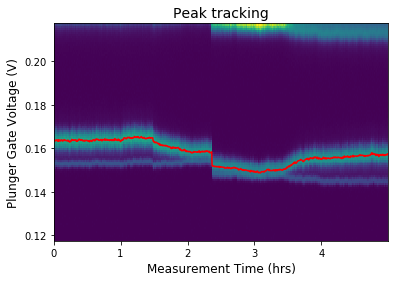

In [41]:
fig, ax1 = plt.subplots()
ax1.set_title("Peak tracking", fontsize = 14)
ax1.set_xlabel("Measurement Time (hrs)", fontsize = 12)
ax1.set_ylabel("Plunger Gate Voltage (V)", fontsize = 12)
ax1.set_axisbelow(True) # pushes grid to background
fig.set_facecolor("White")

len_x = len(tracked_peaks["time_axis"])
data_cut = np.transpose(data_raw[node_r])[:, :len_x]
ax1.pcolor(tracked_peaks["time_axis"]/3600, data_raw[gates], data_cut)
for tracked_peak in tracked_peaks["tracked_peak_positions"]:
    length = min([len(tracked_peaks["time_axis"]), len(tracked_peak)])
    ax1.plot(tracked_peaks["time_axis"][:length]/3600, tracked_peak[:length], color = "r")
#fig.savefig(os.path.join(savepath, "peak_tracking.png"), dpi = 400)

-7.068138872492228
{'popt': array([-6.50419589e-01,  8.54793336e-08]), 'cov': array([[0.01881064, 0.0400142 ],
       [0.0400142 , 0.08801355]]), 'fit_range': [0.0002773946906524992, 0.019417628345674943], 'sigma': array([1.37151904e-01, 5.83917638e-08])}


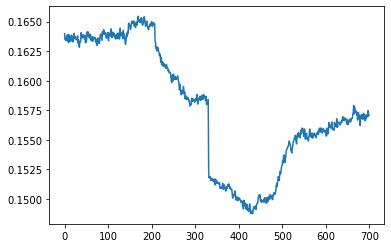

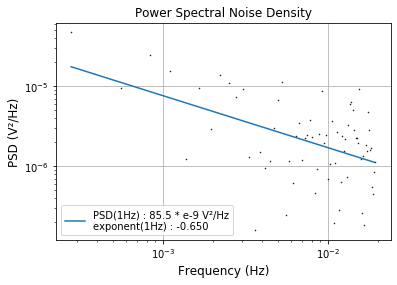

-9.367184210640064
{'popt': array([-1.79788113e+00,  4.29354273e-10]), 'cov': array([[0.01723454, 0.03666148],
       [0.03666148, 0.08063906]]), 'fit_range': [0.0002773946906524992, 0.019417628345674943], 'sigma': array([1.31280371e-01, 2.80739944e-10])}


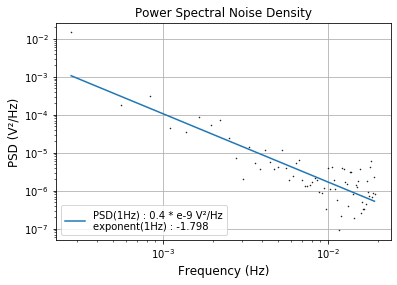

-8.823911129863689
{'popt': array([-1.87822209e+00,  1.49999175e-09]), 'cov': array([[0.0112758 , 0.02398601],
       [0.02398601, 0.05275861]]), 'fit_range': [0.0002773946906524992, 0.019417628345674943], 'sigma': array([1.06187585e-01, 7.93325189e-10])}


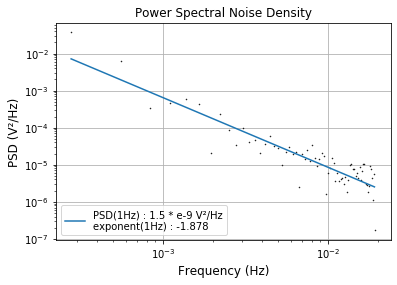

-9.905816349706912
{'popt': array([-2.01279955e+00,  1.24217748e-10]), 'cov': array([[0.0169865 , 0.03613385],
       [0.03613385, 0.07947851]]), 'fit_range': [0.0002773946906524992, 0.019417628345674943], 'sigma': array([1.30332260e-01, 8.06351131e-11])}


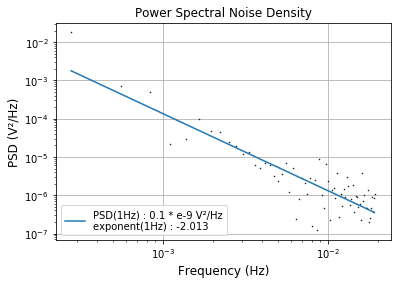

-7.875270926993996
{'popt': array([-1.02903248e+00,  1.33268980e-08]), 'cov': array([[0.0246899 , 0.05252062],
       [0.05252062, 0.11552214]]), 'fit_range': [0.0002773946906524992, 0.019417628345674943], 'sigma': array([1.57130208e-01, 1.04298337e-08])}


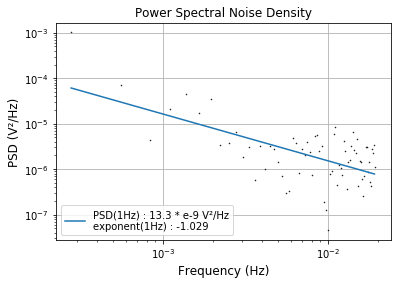

Mean:  3.6069998486601246e-07
Stddev:  2.2821294140496834e-07
Stddev/Mean:  0.6326946242865564


In [58]:
num_slices = 3
peak_no = 0
type_of_fit = "lin"

dejump = 0
min_jump_height = 5e-3

f_min = 5e-4
f_max = 1e-2

saver_overview.add_info(analysis_key, {"sliced_SND" : {"num_slices" : num_slices}})
saver_overview.add_info(analysis_key, {"sliced_SND" : {"peak_no" : peak_no}})
saver_overview.add_info(analysis_key, {"sliced_SND" : {"type_of_fit" : type_of_fit}})
saver_overview.add_info(analysis_key, {"sliced_SND" : {"dejump" : dejump}})
saver_overview.add_info(analysis_key, {"sliced_SND" : {"dejump_min_height" : min_jump_height}})
saver_overview.add_info(analysis_key, {"sliced_SND" : {"integration_limits" : [f_min, f_max]}})

if dejump:
    used_trace = remove_jumps(tracked_peaks["tracked_peak_positions"][peak_no], min_jump_height)
    plt.plot(used_trace)
    plt.plot(tracked_peaks["tracked_peak_positions"][peak_no])
else:
    used_trace = tracked_peaks["tracked_peak_positions"][peak_no]
    plt.plot(used_trace)

from scipy.stats import sem
from scipy import mean

signals = np.array_split(used_trace, num_slices)
sampling_f = tracked_peaks["time_axis"][1]**-1
min_len = min([len(element) for element in signals])

if type_of_fit == "lin":
    fit_func = linear
    guess = [-1, 1]
elif type_of_fit == "bilin":
    fit_func = bilinear2
    guess = [-2, 1, -1, -3]

integrals = []
for i, signal in enumerate(signals):
    #do the signal processing here
    #also save the slices in a way that further parts can understand it.
    noise_calculator = AnalyzerTimetraceSpectralNoiseDensity(signal[:min_len],\
                                                        sampling_f, fit_func = fit_func)
    noise_calculator.guess = guess
    #saver.add_info(f"{node_r}_peak{peak_no}_fit_interval", noise_calculator.fit_interval)
    spectral_result = noise_calculator.analyze()
    #saver.add_info(f"{node_r}_peak{peak_no}_spectrum", spectral_result)
    #saver_overview.add_info(f"{node_r}_peak{peak_no}_spectrum", spectral_result)

    fit = noise_calculator.fit()
    print(fit)
    #saver.add_info(f"{node_r}_peak{peak_no}_SNDfit_parameters", fit)
    #saver_overview.add_info(f"{node_r}_peak{peak_no}_SNDfit_parameters", fit)

    f, s = spectral_result["freq"], spectral_result["spectrogram"]
    saving_path = os.path.join("testfigures", f"{i}")

    plotter_SND = PlotterTimetraceSpectralNoiseDensity(saving_path, [f,s], fit)
    plotter_SND.plot()
    
    #integrate the total noise power


    band = np.linspace(f_min, f_max, 100000)
    spec = func_power2(band, *fit["popt"])
    integrals.append(np.sum(np.diff(band) * spec[:-1]))
    
integral_mean = mean(integrals)
integral_sem = sem(integrals)
print("Mean: ", integral_mean)
print("Stddev: ", integral_sem)
print("Stddev/Mean: ", integral_sem/integral_mean)

saver_overview.add_info(analysis_key, {"sliced_SND" : {"integrals" : integrals}})
saver_overview.add_info(analysis_key, {"sliced_SND" : {"integral_mean" : integral_mean}})
saver_overview.add_info(analysis_key, {"sliced_SND" : {"integral_sem" : integral_sem}})

In [94]:
for file in files.values():
    print(file.keys())

dict_keys(['demod0&4.r4_tracked_peaks', 'demod0&4.r4_peak0_welch_segment_length', 'demod0&4.r4_peak0_fit_interval', 'demod0&4.r4_peak0_spectrum', 'demod0&4.r4_peak0_SNDfit_parameters', 'demod0&4.r4_peak0_jumphist', 'demod0&4.r4_peak0_big_jumps', 'demod0&4.r4_peak0_jumpfit_parameters', 'bias_cooling_parameters'])
dict_keys(['demod0&4.r0_tracked_peaks', 'demod0&4.r0_peak0_welch_segment_length', 'demod0&4.r0_peak0_fit_interval', 'demod0&4.r0_peak0_spectrum', 'demod0&4.r0_peak0_SNDfit_parameters', 'demod0&4.r0_peak0_jumphist', 'demod0&4.r0_peak0_big_jumps', 'demod0&4.r0_peak0_jumpfit_parameters', 'bias_cooling_parameters'])
dict_keys(['demod0&4.r0_tracked_peaks', 'demod0&4.r0_peak0_welch_segment_length', 'demod0&4.r0_peak0_fit_interval', 'demod0&4.r0_peak0_spectrum', 'demod0&4.r0_peak0_SNDfit_parameters', 'bias_cooling_parameters'])
dict_keys(['demod0&4.r4_tracked_peaks', 'demod0&4.r4_peak0_welch_segment_length', 'demod0&4.r4_peak0_fit_interval', 'demod0&4.r4_peak0_spectrum', 'demod0&4.r4_

-8.40542517224761
{'popt': array([-1.35808582e+00,  3.93164980e-09]), 'cov': array([[0.00599063, 0.01461556],
       [0.01461556, 0.03669356]]), 'fit_range': [4.1202825700001986e-05, 0.009723866865200468], 'sigma': array([7.73991664e-02, 1.73414515e-09])}


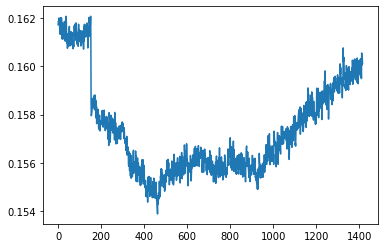

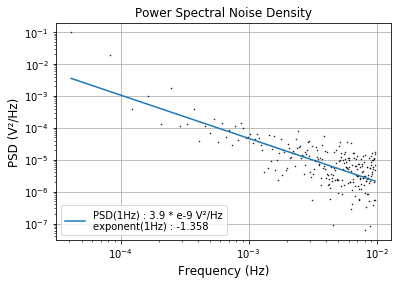

-6.768061985116725
{'popt': array([-6.35551756e-01,  1.70583890e-07]), 'cov': array([[0.00652374, 0.0159162 ],
       [0.0159162 , 0.03995892]]), 'fit_range': [4.1202825700001986e-05, 0.009723866865200468], 'sigma': array([8.07696547e-02, 7.85164360e-08])}


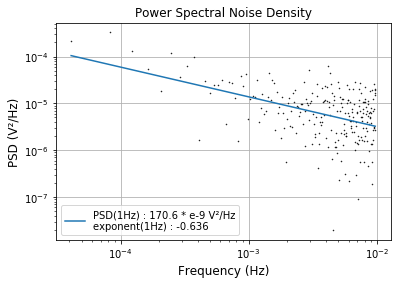

-7.433231021111698
{'popt': array([-9.18629959e-01,  3.68781375e-08]), 'cov': array([[0.00922769, 0.02251313],
       [0.02251313, 0.05652105]]), 'fit_range': [4.1202825700001986e-05, 0.009723866865200468], 'sigma': array([9.60608619e-02, 2.01878373e-08])}


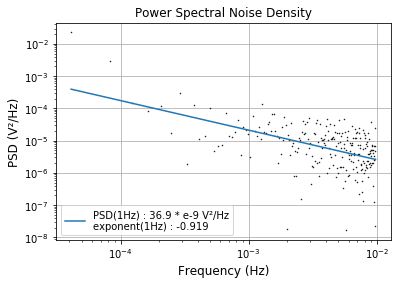

Mean:  7.843926372053899e-08
Stddev:  1.5940480602687182e-08
Stddev/Mean:  0.20322068115630765
-7.137466071875734
{'popt': array([-9.15026052e-01,  7.28675098e-08]), 'cov': array([[0.03246123, 0.06911687],
       [0.06911687, 0.15221583]]), 'fit_range': [0.000255056662524492, 0.01938430635186139], 'sigma': array([1.80169995e-01, 6.54605308e-08])}


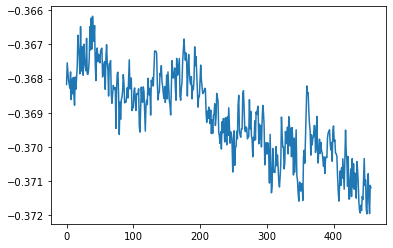

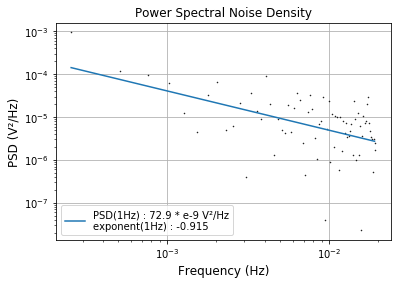

-7.115864834482222
{'popt': array([-8.97977140e-01,  7.65834921e-08]), 'cov': array([[0.02541733, 0.05411892],
       [0.05411892, 0.1191859 ]]), 'fit_range': [0.000255056662524492, 0.01938430635186139], 'sigma': array([1.59428145e-01, 6.08784082e-08])}


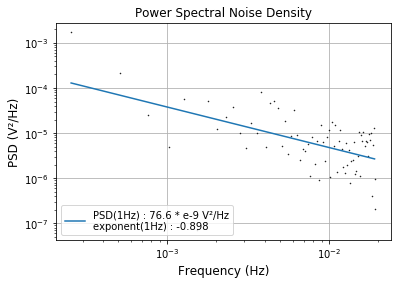

-7.601380390637306
{'popt': array([-1.17315934e+00,  2.50391516e-08]), 'cov': array([[0.02388852, 0.05086374],
       [0.05086374, 0.11201702]]), 'fit_range': [0.000255056662524492, 0.01938430635186139], 'sigma': array([1.54559099e-01, 1.92964451e-08])}


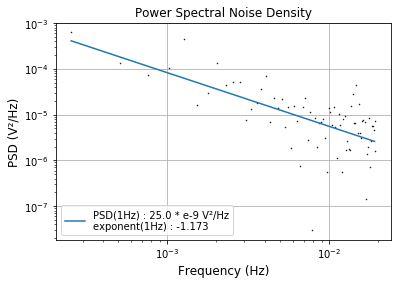

Mean:  1.5738048009669492e-07
Stddev:  3.049827302681431e-08
Stddev/Mean:  0.19378688518471987
-8.119322830970063
{'popt': array([-1.84486584e+00,  7.59761302e-09]), 'cov': array([[0.00130778, 0.00279381],
       [0.00279381, 0.006182  ]]), 'fit_range': [0.0001664198302471788, 0.01930470030867274], 'sigma': array([3.61633060e-02, 1.37548934e-09])}


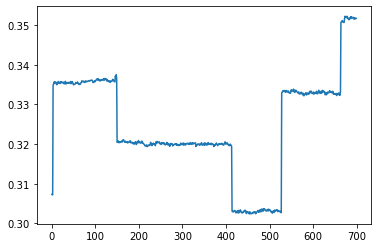

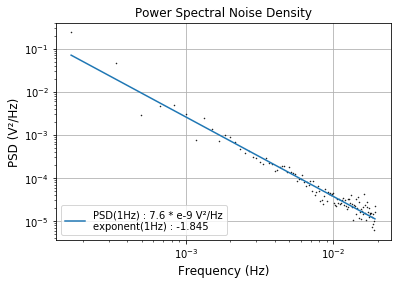

-8.140947668017432
{'popt': array([-1.86155444e+00,  7.22856902e-09]), 'cov': array([[0.00144123, 0.00307889],
       [0.00307889, 0.00681282]]), 'fit_range': [0.0001664198302471788, 0.01930470030867274], 'sigma': array([3.79635715e-02, 1.37382473e-09])}


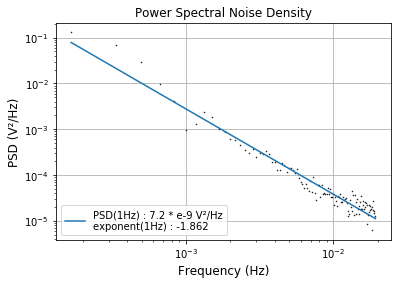

-7.662174515591115
{'popt': array([-1.88393528e+00,  2.17683486e-08]), 'cov': array([[0.00935073, 0.01997587],
       [0.01997587, 0.04420161]]), 'fit_range': [0.0001664198302471788, 0.01930470030867274], 'sigma': array([9.66991758e-02, 1.05380486e-08])}


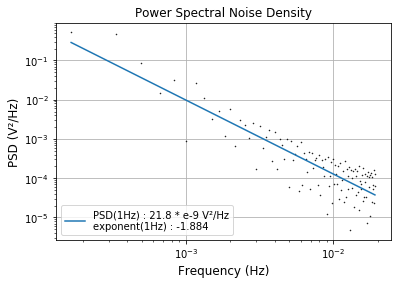

Mean:  9.816732413453718e-06
Stddev:  4.564222966161531e-06
Stddev/Mean:  0.46494319840136583
-7.101694775267475
{'popt': array([-7.47564116e-01,  7.91234517e-08]), 'cov': array([[0.03744183, 0.09076646],
       [0.09076646, 0.22564157]]), 'fit_range': [0.00016771562142346813, 0.009727506042561151], 'sigma': array([1.93498917e-01, 8.65427058e-08])}


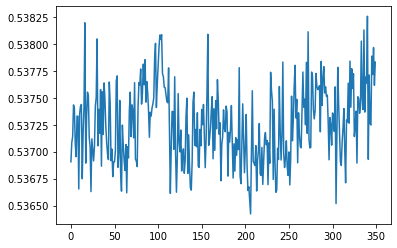

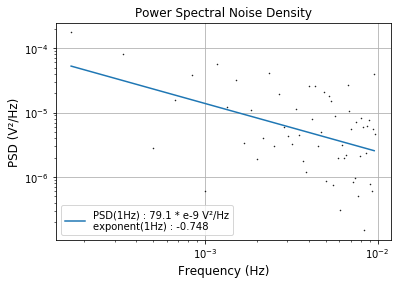

-6.174695193764138
{'popt': array([-3.44513059e-01,  6.68813154e-07]), 'cov': array([[0.03309846, 0.08023726],
       [0.08023726, 0.19946641]]), 'fit_range': [0.00016771562142346813, 0.009727506042561151], 'sigma': array([1.81929811e-01, 6.87789245e-07])}


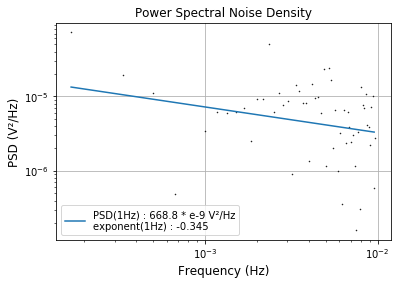

-6.427588895407435
{'popt': array([-4.31750894e-01,  3.73603645e-07]), 'cov': array([[0.05032292, 0.12199279],
       [0.12199279, 0.30326889]]), 'fit_range': [0.00016771562142346813, 0.009727506042561151], 'sigma': array([2.24327705e-01, 4.73740728e-07])}


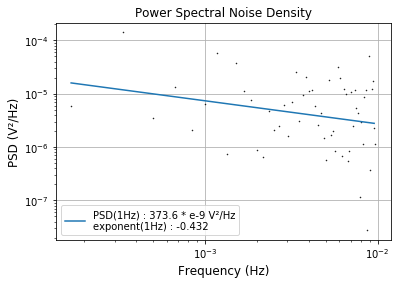

Mean:  4.471046976622739e-08
Stddev:  3.791649910217819e-09
Stddev/Mean:  0.0848045196134774
-6.353011604314411
{'popt': array([-5.78345525e-01,  4.43596791e-07]), 'cov': array([[0.03671072, 0.07791669],
       [0.07791669, 0.17087042]]), 'fit_range': [0.0003359868861199787, 0.019487239394958764], 'sigma': array([1.91600414e-01, 4.22218761e-07])}


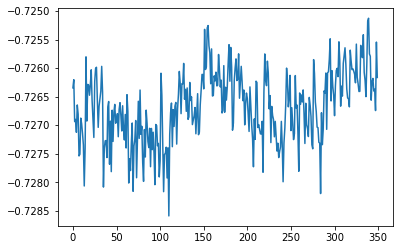

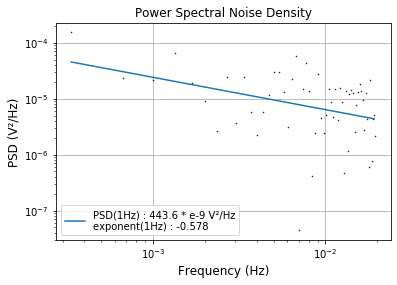

-7.508121394968624
{'popt': array([-1.04070619e+00,  3.10369192e-08]), 'cov': array([[0.02948051, 0.06257092],
       [0.06257092, 0.13721733]]), 'fit_range': [0.0003359868861199787, 0.019487239394958764], 'sigma': array([1.71698888e-01, 2.64727329e-08])}


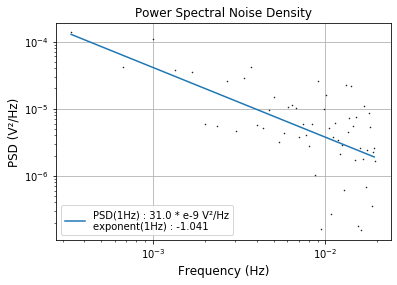

-7.089319616002394
{'popt': array([-8.60291687e-01,  8.14104929e-08]), 'cov': array([[0.03477769, 0.07381394],
       [0.07381394, 0.16187314]]), 'fit_range': [0.0003359868861199787, 0.019487239394958764], 'sigma': array([1.86487785e-01, 7.54194685e-08])}


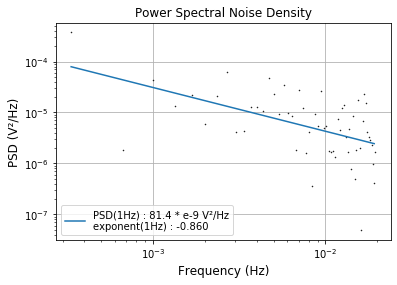

Mean:  1.1074864086875394e-07
Stddev:  4.3832369925899834e-09
Stddev/Mean:  0.03957824636226888


In [98]:
num_slices = 3
peak_no = 0
type_of_fit = "lin"

dejump = 0
min_jump_height = 5e-3

f_min = 5e-4
f_max = 1e-2

overview_path = "/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/"
saver_overview = Saver_json(overview_path)
saver_overview.fname = "P35B4_post_analysis_wjumps2"
saver_overview.append_to_file = True

for file in chosen_measurements.values():
    bcv = file["bias_cooling_parameters"]["bcv"]
    tgv = file["bias_cooling_parameters"][f"{side}tgv"]
    vr = file["bias_cooling_parameters"]["vref"]
    analysis_key = f"{bcv}tg{tgv}vr{vr}side{side}"
    
    demod_prefix = "demod0&4"
    if side == "l":
        demod_idx = 0
    else:
        demod_idx = 4

    node_timestamp = f"{demod_prefix}.timestamp{demod_idx}"
    node_x = f"{demod_prefix}.x{demod_idx}"
    node_y = f"{demod_prefix}.y{demod_idx}"
    node_r = f"{demod_prefix}.r{demod_idx}"

    gates = "gates_6_16"
    tracked_peaks = file[f"{node_r}_tracked_peaks"]
    
    saver_overview.add_info(analysis_key, {"sliced_SND" : {"num_slices" : num_slices}})
    saver_overview.add_info(analysis_key, {"sliced_SND" : {"peak_no" : peak_no}})
    saver_overview.add_info(analysis_key, {"sliced_SND" : {"type_of_fit" : type_of_fit}})
    saver_overview.add_info(analysis_key, {"sliced_SND" : {"dejump" : dejump}})
    saver_overview.add_info(analysis_key, {"sliced_SND" : {"dejump_min_height" : min_jump_height}})
    saver_overview.add_info(analysis_key, {"sliced_SND" : {"integration_limits" : [f_min, f_max]}})

    if dejump:
        used_trace = remove_jumps(tracked_peaks["tracked_peak_positions"][peak_no], min_jump_height)
        plt.plot(used_trace)
        plt.plot(tracked_peaks["tracked_peak_positions"][peak_no])
    else:
        used_trace = tracked_peaks["tracked_peak_positions"][peak_no]
        plt.plot(used_trace)


    signals = np.array_split(used_trace, num_slices)
    sampling_f = tracked_peaks["time_axis"][1]**-1
    min_len = min([len(element) for element in signals])

    if type_of_fit == "lin":
        fit_func = linear
        guess = [-1, 1]
    elif type_of_fit == "bilin":
        fit_func = bilinear2
        guess = [-2, 1, -1, -3]

    integrals = []
    for i, signal in enumerate(signals):
        #do the signal processing here
        #also save the slices in a way that further parts can understand it.
        noise_calculator = AnalyzerTimetraceSpectralNoiseDensity(signal[:min_len],\
                                                            sampling_f, fit_func = fit_func)
        noise_calculator.guess = guess
        #saver.add_info(f"{node_r}_peak{peak_no}_fit_interval", noise_calculator.fit_interval)
        spectral_result = noise_calculator.analyze()
        #saver.add_info(f"{node_r}_peak{peak_no}_spectrum", spectral_result)
        #saver_overview.add_info(f"{node_r}_peak{peak_no}_spectrum", spectral_result)

        fit = noise_calculator.fit()
        print(fit)
        #saver.add_info(f"{node_r}_peak{peak_no}_SNDfit_parameters", fit)
        #saver_overview.add_info(f"{node_r}_peak{peak_no}_SNDfit_parameters", fit)

        f, s = spectral_result["freq"], spectral_result["spectrogram"]
        saving_path = os.path.join("testfigures", f"{i}")

        plotter_SND = PlotterTimetraceSpectralNoiseDensity(saving_path, [f,s], fit)
        plotter_SND.plot()

        #integrate the total noise power


        band = np.linspace(f_min, f_max, 100000)
        spec = func_power2(band, *fit["popt"])
        integrals.append(np.sum(np.diff(band) * spec[:-1]))

    integral_mean = mean(integrals)
    integral_sem = sem(integrals)
    print("Mean: ", integral_mean)
    print("Stddev: ", integral_sem)
    print("Stddev/Mean: ", integral_sem/integral_mean)

    saver_overview.add_info(analysis_key, {"sliced_SND" : {"integrals" : integrals}})
    saver_overview.add_info(analysis_key, {"sliced_SND" : {"integral_mean" : integral_mean}})
    saver_overview.add_info(analysis_key, {"sliced_SND" : {"integral_sem" : integral_sem}})

In [99]:
saver_overview.save()

# Remove large jumps

In [5]:
def remove_jumps(peak_track, jump_min_height):
    difference = np.diff(peak_track)
    jumps_height = difference[abs(difference) >= jump_min_height]
    jumps_idx = np.flatnonzero(abs(difference) >= jump_min_height) + 1
    
    prev_idx = 0
    jumped = 0
    baseline = np.array([])
    
    for idx, height in zip(jumps_idx, jumps_height):
        len_x = idx - prev_idx
        prev_idx = idx    
        baseline = np.concatenate((baseline, np.full(len_x, jumped)))
        jumped += height

    baseline = np.concatenate((baseline, np.full(len(peak_track) - len(baseline), jumped)))
    return peak_track - baseline

def linear(x, a, b):
    return a * x + b

def bilinear2(x, a, b, c, switch_point):
    x = np.array(x)
    part1 = a * x[x <= switch_point] + b
    part2 = c * x[x > switch_point] + (a - c) * switch_point + b
    return np.concatenate((part1, part2))

In [4]:
date_time_string = "20220502/014148"#"20220518/211236"
date = date_time_string.split("/")[0]
time = date_time_string.split("/")[1]
filepath = f"sftp://tp1435@os-login.lsdf.kit.edu/kit/phi/projects/nanospin/SEMICONDUCTOR_SYSTEMS/data/{date}/{time}_2D_Peak_tracking/{time}_2D_Peak_tracking.h5"
savepath = os.path.join("/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/",
                        str(pathlib.Path(filepath).parents[1]).split("/")[-1],
                        str(pathlib.Path(filepath).parents[0]).split("/")[-1])

configpath = "/home/ws/lr1740/Dokumente/Doktorarbeit/Sonstiges/sftp_config.txt"
overview_path = "/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/"

saver = Saver_json(savepath)
saver.append_to_file = True
saver_overview = Saver_json(overview_path)
bcv = input("Specify current bias cooling voltage in V: ")

saver_overview.fname = "P35B3_post_analysis"
saver_overview.append_to_file = True

print("Savepath: " + savepath)

settings = {"file_info" : {
                "filepath" : filepath,
                "savepath" : savepath,
                "analysis" : "plunger_sweep_timetrace"},
            "authentication" : {
                "configpath" : configpath}
            }

analyzed_path = (f"/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project"
                 f"/Analysis/{date}/{time}_2D_Peak_tracking/analyzed_data.json")

loader_analyzed = LoaderJSON()
data_analyzed = loader_analyzed.load(analyzed_path)

Specify current bias cooling voltage in V: 0.75
Savepath: /V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/20220502/014148_2D_Peak_tracking


In [5]:
loader = Loaderh5()
data_raw, _ = loader.load(settings)
print(data_raw.keys())
print("\n")
print(data_raw["static_voltages"])
vr = input("Specify reference votlage in V: ")

Done loading file, formatting now...
dict_keys(['demod0&4.r0', 'demod0&4.r4', 'demod0&4.timestamp0', 'demod0&4.timestamp4', 'demod0&4.x0', 'demod0&4.x4', 'demod0&4.y0', 'demod0&4.y4', 'gates_6_16', 'measurement', 'number', 'settings', 'static_voltages'])


['{\n    "gate10_out": 0.604248046875,\n    "gate11_out": 0.604248046875,\n    "gate12_out": 0.604248046875,\n    "gate13_out": 0.604248046875,\n    "gate14_out": 1.41387939453125,\n    "gate15_out": 0.75958251953125,\n    "gate16_out": 0.64422607421875,\n    "gate17_out": 0.6915283203125,\n    "gate18_out": 0.604248046875,\n    "gate19_out": 0.604248046875,\n    "gate20_out": 0.604248046875,\n    "gate21_out": 0.604248046875,\n    "gate22_out": 0.604248046875,\n    "gate23_out": 0.604248046875,\n    "gate4_out": 1.239013671875,\n    "gate5_out": 0.62652587890625,\n    "gate6_out": 0.604248046875,\n    "gate7_out": 0.57830810546875,\n    "gate9_out": 0.604248046875\n}']
Specify reference votlage in V: 0.604


In [6]:
side = input("Specify side of SET (l/r): ")
tgv = input("Specify current top gate voltage in V: ")
while side != "l" and side != "r":
    side = input("Specify side of SET (l/r): ")

demod_prefix = "demod0&4"
if side == "l":
    demod_idx = 0
else:
    demod_idx = 4
    
node_timestamp = f"{demod_prefix}.timestamp{demod_idx}"
node_x = f"{demod_prefix}.x{demod_idx}"
node_y = f"{demod_prefix}.y{demod_idx}"
node_r = f"{demod_prefix}.r{demod_idx}"

gates = "gates_6_16"
tracked_peaks = data_analyzed[f"{node_r}_tracked_peaks"]
analysis_key = f"{bcv}tg{tgv}vr{vr}side{side}"

Specify side of SET (l/r): l
Specify current top gate voltage in V: 1.239


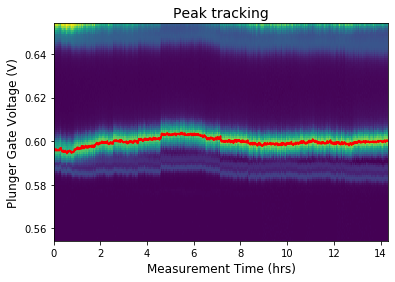

In [7]:
fig, ax1 = plt.subplots()
ax1.set_title("Peak tracking", fontsize = 14)
ax1.set_xlabel("Measurement Time (hrs)", fontsize = 12)
ax1.set_ylabel("Plunger Gate Voltage (V)", fontsize = 12)
ax1.set_axisbelow(True) # pushes grid to background
fig.set_facecolor("White")

len_x = len(tracked_peaks["time_axis"])
data_cut = np.transpose(data_raw[node_r])[:, :len_x]
ax1.pcolor(tracked_peaks["time_axis"]/3600, data_raw[gates], data_cut)
for tracked_peak in tracked_peaks["tracked_peak_positions"]:
    length = min([len(tracked_peaks["time_axis"]), len(tracked_peak)])
    ax1.plot(tracked_peaks["time_axis"][:length]/3600, tracked_peak[:length], color = "r")
#fig.savefig(os.path.join(savepath, "peak_tracking.png"), dpi = 400)

In [8]:
peak_no = 0
dejumped_trace = remove_jumps(tracked_peaks["tracked_peak_positions"][peak_no], 5e-3)
saver.add_info(f"{node_r}_peak{peak_no}_trace_dejumped", dejumped_trace)
plt.plot(tracked_peaks["tracked_peak_positions"][peak_no])
plt.plot(dejumped_trace)

NameError: name 'remove_jumps' is not defined

-14.227767080950168
-2.983231237223958


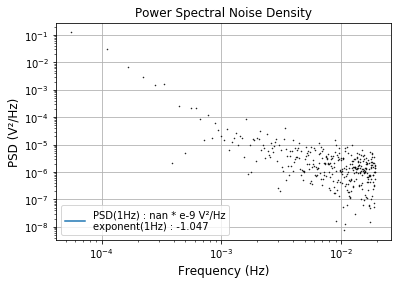

In [101]:
type_of_fit = "bilin"
if type_of_fit == "lin":
    fit_func = linear
    guess = [-1, 1]
elif type_of_fit == "bilin":
    fit_func = bilinear2
    guess = [-2, 1, -1, -3]
    
sampling_f = tracked_peaks["time_axis"][1]**-1
noise_calculator = AnalyzerTimetraceSpectralNoiseDensity(dejumped_trace,\
                                                        sampling_f, fit_func = fit_func)

noise_calculator.welch_segment_length = 300
noise_calculator.guess = guess
saver.add_info(f"{node_r}_peak{peak_no}_welch_segment_length_dejumped", noise_calculator.welch_segment_length)
saver.add_info(f"{node_r}_peak{peak_no}_fit_interval_dejumped", noise_calculator.fit_interval)

spectral_result = noise_calculator.analyze()
saver.add_info(f"{node_r}_peak{peak_no}_spectrum_dejumped", spectral_result)
saver_overview.add_info(f"{node_r}_peak{peak_no}_spectrum_dejumped", spectral_result)

fit = noise_calculator.fit()
saver.add_info(f"{node_r}_peak{peak_no}_SNDfit_parameters_dejumped", fit)
saver_overview.add_info(f"{node_r}_peak{peak_no}_SNDfit_parameters_dejumped", fit)

f, s = spectral_result["freq"], spectral_result["spectrogram"]
saving_path = os.path.join(settings["file_info"]["savepath"], f"{node_r}_dejumped")

plotter_SND = PlotterTimetraceSpectralNoiseDensity(saving_path, [f,s], fit)
plotter_SND.plot()

In [98]:
fit

{'popt': array([ -3.13346752, -14.22776708,  -1.04706232,  -2.98323124]),
 'cov': array([[1.46591041e-01, 4.95146684e-01, 6.62740958e-10, 2.77174613e-02],
        [4.95146684e-01, 1.68926684e+00, 2.27044854e-09, 1.01669378e-01],
        [6.62741827e-10, 2.27045147e-09, 9.83040160e-03, 4.28267557e-03],
        [2.77174613e-02, 1.01669378e-01, 4.28267557e-03, 1.11725527e-02]]),
 'fit_range': [5.547893813049984e-05, 0.019417628345674943],
 'sigma': array([3.82872095e-01, 1.77132290e-14, 9.91483817e-02, 2.52965129e-04])}

Sigmas:  [0.1371519  0.29667078]
Fit params:  [-6.50419589e-01  8.54793336e-08]
Bounds lower:  [-0.78757149 -0.2966707 ]
Bounds higher:  [-0.51326769  0.29667087]
Fit params:  [-0.65041959  1.0000002 ]
Bounds_lower:  [-0.78757149  0.5050441 ]
Bounds_upper:  [-0.51326769  1.98002589]


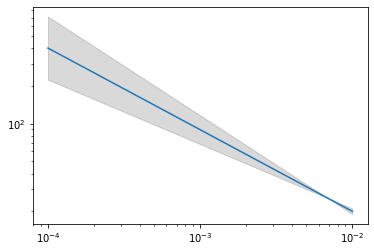

In [28]:
def func_power2(x, *params):
    if len(params) == 2:
        return params[1] * x ** params[0]
    else:
        part1 = params[1] * x[x <= params[3]] ** params[0]
        part2 = params[1]/(params[3] ** (params[2]-params[0])) * x[x > params[3]] ** params[2]
        return np.concatenate((part1, part2))
    
sigmas = np.sqrt(np.diagonal(fit["cov"]))

print("Sigmas: ", sigmas)
print("Fit params: ", fit["popt"])
print("Bounds lower: ", fit["popt"] - sigmas)
print("Bounds higher: ", fit["popt"] + sigmas)

original = fit["popt"]
bound_upper = fit["popt"] + sigmas
bound_lower = fit["popt"] - sigmas

for index in range(0, len(original), 2):
    original[index + 1] = 10**original[index + 1]
    
for index in range(0, len(bound_lower), 2):
    bound_lower[index + 1] = 10**bound_lower[index + 1]
    
for index in range(0, len(bound_upper), 2):
    bound_upper[index + 1] = 10**bound_upper[index + 1]
    
print("Fit params: ", original)
print("Bounds_lower: ", bound_lower)
print("Bounds_upper: ", bound_upper)

freqs = np.linspace(1e-4, 1e-2, 1000)

plt.plot(freqs, func_power2(freqs, *original))
#plt.plot(freqs, func_power2(freqs, *bound_lower))
#plt.plot(freqs, func_power2(freqs, *bound_upper))
plt.fill_between(freqs, func_power2(freqs, *bound_lower), func_power2(freqs, *bound_upper),
                 color = 'black', alpha = 0.15)
plt.xscale("log")
plt.yscale("log")

In [172]:
saver.save()

ovw = saver_overview.additional_info

saver_saver_overview = Saver_json(overview_path) #Save your saved data to be safe
analysis_key = f"{bcv}tg{tgv}vr{vr}side{side}"

saver_saver_overview.fname = saver_overview.fname
saver_saver_overview.append_to_file = True

saver_saver_overview.additional_info = {analysis_key : ovw}
saver_saver_overview.save()

# Plot 

In [6]:
class Plot_formatter:
    def __init__(self):
        self.fig_facecolor= "White"
        self.axisbelow = True
        self.title_fontsize = 14
        self.xaxis_fontsize = 12
        self.yaxis_fontsize = 12
        
    def format_fig(self, fig):
        fig.set_facecolor(self.fig_facecolor)
    
    def format_ax(self, ax):
        ax.set_axisbelow(self.axisbelow) # pushes grid to background
        ax.title.set_size(self.title_fontsize)
        ax.xaxis.label.set_size(self.xaxis_fontsize)
        ax.yaxis.label.set_size(self.yaxis_fontsize)
        ax.grid()

## with errorbars

In [100]:
sample = "P35B4_post_analysis_wjumps2"
fname = f"{sample}.json"

overview_path = "/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/"

loader = LoaderJSON()
ovw_data = loader.load(os.path.join(overview_path, fname))
ovw_data.keys()

dict_keys(['0.0tg0.703vr0.703sidel', '-0.5tg0.442vr0.129sidel', '0.25tg1.429vr0.699sidel', '0.75tg1.104vr1.104sidel', '-1.0tg0.212vr-0.209sidel'])

-1.0
-0.5
0.0
0.25
0.75
[1.1074864086875394e-07, 1.5738048009669492e-07, 7.843926372053899e-08, 9.816732413453718e-06, 4.471046976622739e-08]


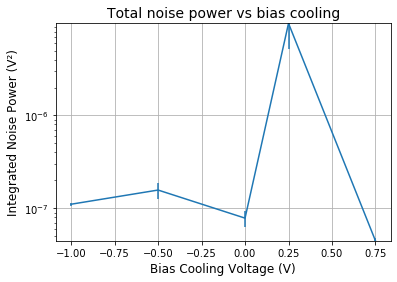

In [101]:
class bias_cool_plotter_werr():
    def __init__(self, data_dict, y_maker, sample, y_scale = "log"):
        self.data_dict = data_dict
        self.y_maker = y_maker
        self._build_x_axis()
        self._build_y_axis()
        print(self.y_axis)
        self.fig, self.ax1 = plt.subplots()
        self.ax1.set_title("Total noise power vs bias cooling")
        self.ax1.set_xlabel("Bias Cooling Voltage (V)")
        self.ax1.set_ylabel("Integrated Noise Power (V²)")
        self.ax1.set_yscale(y_scale)
        self.ax1.set_ylim(min(self.y_axis), max(self.y_axis))
        self.ax1.errorbar(self.x_axis, self.y_axis, self.y_errs)
        
        self.set_dpi = 400
        self.pf = Plot_formatter()
        self.fig.save_as = ".png"
        self.pf.format_fig(self.fig)
        self.pf.format_ax(self.ax1)
        self.fig.savefig(os.path.join(overview_path, f"{sample}_integrated_noise.png"), dpi = self.set_dpi)
    
    def _build_x_axis(self):
        x_vals = set()
        for key in self.data_dict.keys():
            bcv = get_bcv(key)
            x_vals.add(bcv)
        self.x_axis = sorted(list(x_vals))
    
    def _build_y_axis(self):
        self.y_axis = []
        self.y_errs = []
        for x_value in self.x_axis:
            y_value, y_err = self.y_maker(self.data_dict, x_value)
            self.y_axis.append(y_value)
            self.y_errs.append(y_err)
            
def integrated_noise_power_fit_werr(data_dict, x_value):
    print(x_value)
    tgv, key = extract_lowest_tgv(x_value, "l", data_dict)
    if not tgv:
        return np.nan, np.nan
    elif "sliced_SND" in data_dict[key].keys():
        mean = data_dict[key]["sliced_SND"]["integral_mean"]
        sem = data_dict[key]["sliced_SND"]["integral_sem"]
        return mean, sem
    else:
        return np.nan, np.nan
    
    
bcp_werr = bias_cool_plotter_werr(ovw_data, integrated_noise_power_fit_werr, sample)

## all samples in one plot

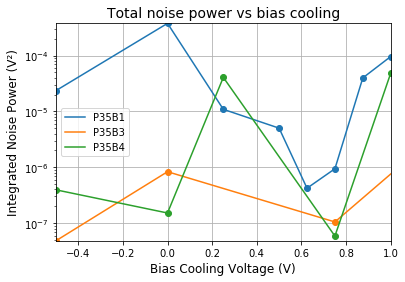

In [103]:
fig, ax1 = plt.subplots()
ax1.set_title("Total noise power vs bias cooling")
ax1.set_xlabel("Bias Cooling Voltage (V)")
ax1.set_ylabel("Integrated Noise Power (V²)")
ax1.set_yscale("log")
ax1.set_xlim(-0.5, 1)

all_y_vals = []
all_y_vals.extend(p35_b1_y_axis)
all_y_vals.extend(p35_b3_y_axis)
all_y_vals.extend(p35_b4_y_axis)

ax1.set_ylim(min(all_y_vals), max(all_y_vals))
ax1.plot(p35_b1_x_axis, p35_b1_y_axis, label = "P35B1")
ax1.plot(p35_b3_x_axis, p35_b3_y_axis, label = "P35B3")
ax1.plot(p35_b4_x_axis, p35_b4_y_axis, label = "P35B4")
ax1.scatter(p35_b1_x_axis, p35_b1_y_axis)
ax1.scatter(p35_b3_x_axis, p35_b3_y_axis)
ax1.scatter(p35_b4_x_axis, p35_b4_y_axis)
ax1.legend()

plot_format = Plot_formatter()
plot_format.format_fig(fig)
plot_format.format_ax(ax1)

fig.savefig(os.path.join(overview_path, f"AllSample_integrated_noise.png"), dpi = 1200)

In [104]:
p35_b3_x_axis

[-0.5, 0.0, 0.75, 1.5]

In [95]:
min([[0,3],[-1,5]])

[-1, 5]

In [97]:
print(p35_b1_x_axis)
print(p35_b3_x_axis)
print(p35_b4_x_axis)

[-4.0, -0.5, 0.0, 0.25, 0.5, 0.625, 0.75, 0.875, 1.0, 1.5, 2.5]
[-0.5, 0.0, 0.75, 1.5]
[-1.0, -0.5, 0.0, 0.25, 0.75, 1.0]
